# Problem klas niezbalansowanych 

### Przykłady:  
* fraudy na kartach kredytowych
* analiza żywotności urządzeń
* analizy medyczne (wykrywanie chorób)
* rekomendacja reklam

### Co się dzieje w praktyce? 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

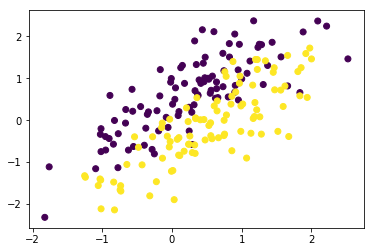

In [2]:
SIZE_1 = 100
SIZE_2 = 100
C_1 = np.array([[0, -0.23], [0.83, 0.93]])
C_2 = C_1 
M1 = np.array([0.25, 0.5])
M2 = M1 + np.array([0.28, -0.34])*1.5
X_0 = np.random.multivariate_normal(M1, C_1, SIZE_1)
X_1 = np.random.multivariate_normal(M2, C_2, SIZE_2)

X = np.vstack([X_0, X_1])
y = np.array([0]*SIZE_1 + [1]*SIZE_2)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
def plot_model_decision(model, X, y, model2=None):
    nx, ny = 200, 200
    x_min, x_max = X.min()-1, X.max()+1
    y_min, y_max = X.min()-1, X.max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))

    Z = model.fit(X, y).predict_proba(np.c_[xx.ravel(), yy.ravel()])

    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=0.5)
    C = plt.contour(xx, yy, Z, [0.5], linewidths=2.)
    if model2 is not None:
        Z2 = model2.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z2 = Z2[:, 1].reshape(xx.shape)
        plt.contour(xx, yy, Z2, [0.5], linewidths=2., linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolors='black')
    plt.show()

### Granica decyzyjna dla klas zbalansowanych

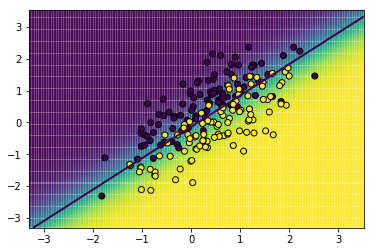

In [4]:
model = LogisticRegression()
model.fit(X, y)
plot_model_decision(model, X, y)

In [5]:
SIZE_2

100

### Tworzenie zbiorow niezbalansowanych

In [6]:
SMALLER_SIZE=20
indices = np.random.choice(SIZE_2, size=SMALLER_SIZE, replace=False)

In [7]:
indices

array([29,  2, 77, 31, 55, 27, 92, 82, 93, 60, 89,  4,  9, 91, 50, 16, 52,
       67, 15, 62])

In [8]:
X_0.shape

(100, 2)

In [9]:
X_1[indices, :].shape

(20, 2)

In [10]:
X_smaller = np.vstack([X_0, X_1[indices, :]])

y_smaller = np.array([0]*SIZE_1 + [1]*SMALLER_SIZE)

In [11]:
df_smaller = np.hstack([X_smaller,y_smaller[:,np.newaxis]])

In [12]:
df_smaller.shape

(120, 3)

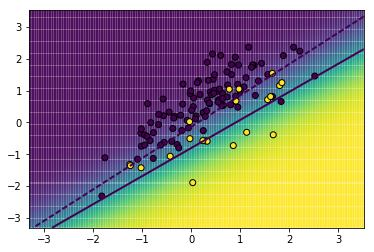

In [13]:
model_inb = LogisticRegression()
plot_model_decision(model_inb, X_smaller, y_smaller, model2=model)

Widać, że pomimo tego, że dane pochodzą z tego samego rozkładu co wcześniej, bardzo mocno zmieniła się granica decyzyjna, i w praktyce nie rozdziela już obu rozkładów tak dobrze jak przy zbalansowanych klasach.

### Co możemy z tym zrobić? 

#### 1. Undersampling 

W sytuacji, kiedy jednej klasy jest więcej niż drugiej, możemy losowo usunąć obserwacje z liczniejszej klasy, sprowadzając wtedy problem do sytuacji kiedy obie grupy są równoliczne.  

In [30]:
df_smaller_0 = df_smaller[y_smaller==0]
df_smaller_0.shape

(100, 3)

In [31]:
df_smaller_1 = df_smaller[y_smaller==1]
df_smaller_1.shape

(20, 3)

In [32]:
df_smaller_0_undersampl = resample(df_smaller_0,replace=False,n_samples=df_smaller_1.shape[0])

In [33]:
df_undersampl = np.vstack([df_smaller_0_undersampl,df_smaller_1])
df_undersampl.shape

(40, 3)

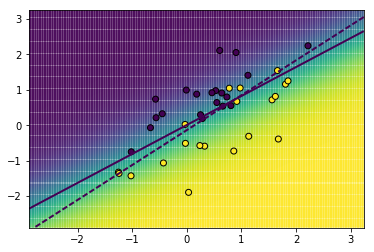

In [34]:
model_undersampl = LogisticRegression()
plot_model_decision(model_undersampl,df_undersampl[:,:2],df_undersampl[:,-1],model2=model)

#### 2. Oversampling 

Drugą techniką jest sztuczne zwiększenie liczności jednej z klas poprzez dopróbkowanie obserwacji. Dzięki temu wyrównujemy wielkości obu klas, ale w przeciwieństwie do poprzedniej strategii, nie tracimy informacji.

In [38]:
df_smaller_1_oversampl = resample(df_smaller_1,replace=True,n_samples=df_smaller_0.shape[0])
df_smaller_1_oversampl.shape

(100, 3)

In [39]:
df_oversampl = np.vstack([df_smaller_0,df_smaller_1_oversampl])
df_oversampl.shape

(200, 3)

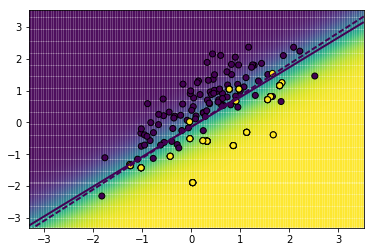

In [40]:
model_oversampl = LogisticRegression()
plot_model_decision(model_oversampl,df_oversampl[:,:2],df_oversampl[:,-1],model2=model)

#### 3. Ważona funkcja straty 

Główną przyczyną takiego zachowania modelu jest to, że wartości funkcji straty dla obserwacji z mniej licznej klasy mają proporcjonalnie mniejszy wkład w jej wartość, niż obserwacje z bardziej licznej klasy. Dzięki temu klasyfikator "uczy się", że nie ma sensu dopasowywać się do tych mniej licznych obserwacji, bo zysk z tego będzie niewielki. Możemy więc nadać każdemu punktowi odpowiednią wagę (zależną od klasy) tak, aby zrównoważyło to braki w liczności.

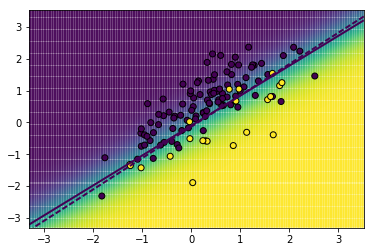

In [41]:
model_weighted = LogisticRegression(class_weight={0:1, 1:5})
plot_model_decision(model_weighted, X_smaller, y_smaller, model2=model)

#### 4. Zmiana progu decyzyjnego 

Zmniejszenie liczności jednej z klas powoduje, że prawdopodobieństwa 'przesuwają się' w stronę liczniejszej klasy. Spójrzmy na chwilę na wzór Bayesa:

$$ p(C_k \mid \mathbf{x}) =  \frac{p(C_k) \ p(\mathbf{x} \mid C_k)}{p(\mathbf{x})}.$$

Widzimy że przy niezbalansowanych klasach mocno zmienia się $p(C_k)$ w zależności od $k$. Przez to dla klasy o mniejszej liczności potrzebujemy naprawdę mocnych dowodów na to że $x$ pochodzi z klasy $k$ (czyli wysokie $p(\mathbf{x} \mid C_k)$) aby przekroczyć próg 0.5.  

Prostym rozwiązaniem jest po prostu odrzucenie klasycznego progu równego $0.5$ i przesunięcie go w odpowiednią stronę.

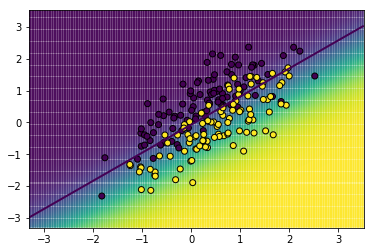

In [42]:
model_shifted = LogisticRegression()

nx, ny = 200, 200
x_min, x_max = X.min()-1, X.max()+1
y_min, y_max = X.min()-1, X.max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))

Z = model_shifted.fit(X_smaller, y_smaller).predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, alpha=0.5)
C = plt.contour(xx, yy, Z, [0.2], linewidths=2.)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolors='black')
plt.show()

### Dobre rady - o czym warto pamiętać: 

* **dobór odpowiedniej metryki** - przy walidacji modelu dostaliśmy *accuracy* równe 99%. Czy model jest dobry? *Nie wiemy.* Jeśli klasy są mocno niezbalansowane (np. 99:1) to najprawdopodobniej model przypisał wszytki obserwacjom liczniejszą klasę. Lepiej używać metryk opartych o prawdopodobieństwa, a nie o klasy - na przykład AUC.  
* **warstwowa walidacja krzyżowa** - jeśli używamy walidacji krzyżowej, to warto pamiętać o tym, aby w każdej próbce były takie same proporcje między licznościami klas. W przeciwnym wypadku próbki mogą nie oddawać dobrze naszej całej próby, co z kolei doprowadzi do złej estymacji jakości modelu.


In [43]:
from sklearn.model_selection import StratifiedKFold

#### Case study 

W pliku `creditcardfraud.csv` znajdziecie plik z danymi o transakcjach kartami płatniczymi wraz z informacją, czy dana transakcja to fraud. Zbadaj dane pod kątem ich niezbalansowania. Zaproponuj metrykę którą ocenisz jakość predykcji, a następnie zbuduj jak najlepszy model pod kątem tej metryki.

In [45]:
import numpy  as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

In [46]:
data = pd.read_csv('Data/creditcard.csv')

In [47]:
data.shape

(284807, 31)

In [48]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [49]:
data['Class'].mean()

0.001727485630620034

In [50]:
data[data.Class==0].shape

(284315, 31)

In [51]:
data[data.Class==1].shape

(492, 31)

### Random forest with auc scoring and weighted cost function

In [52]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [53]:
forest = RandomForestClassifier(class_weight='balanced')

In [54]:
forest_result = cross_val_score(forest,X,y,scoring='roc_auc',cv=StratifiedKFold(5,shuffle=True),n_jobs=-1)
print(forest_result)
print(forest_result.mean())

[ 0.90870393  0.91889606  0.93857982  0.94868296  0.93337307]
0.929647167783


In [55]:
params_forest = {
    'min_samples_leaf': [10],
    'n_estimators':[50]
}

In [56]:
grid_forest = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                          param_grid = params_forest,
                          scoring = 'roc_auc',
                          cv = StratifiedKFold(5,shuffle=True),
                          n_jobs = -1)
grid_forest.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [10], 'n_estimators': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [57]:
grid_forest.best_score_

0.96116983017294455

In [58]:
grid_forest.best_params_

{'min_samples_leaf': 10, 'n_estimators': 50}

In [59]:
best_forest = grid_forest.best_estimator_

In [60]:
roc_auc_score(y_true=y,
              y_score=best_forest.predict_proba(X)[:,1])

0.99995514822460896

In [61]:
(fpr_forest,tpr_forest,_) = roc_curve(y_true=y,
                                      y_score=best_forest.predict_proba(X)[:,1])

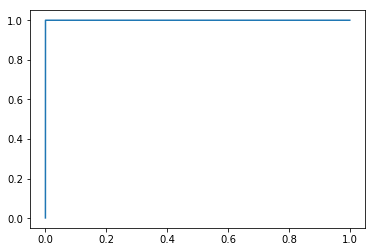

In [62]:
plt.plot(fpr_forest,tpr_forest)
plt.show()

### Weighted cost function and Logistic regression

In [63]:
log_weight_pipeline = Pipeline([
    ('scaling',MinMaxScaler()),
    ('log_reg',LogisticRegression(class_weight='balanced'))
]) 

In [64]:
log_weight_param = {
    'log_reg__penalty':['l2'],
    'log_reg__C':[1.0]
}

In [65]:
grid_log_weight = GridSearchCV(log_weight_pipeline,
                              param_grid=log_weight_param,
                              cv=StratifiedKFold(5,shuffle=True),
                              scoring='roc_auc',
                              n_jobs=-1)
grid_log_weight.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('log_reg', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'log_reg__penalty': ['l2'], 'log_reg__C': [1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [69]:
grid_log_weight.best_score_

0.97914711416095823

In [70]:
roc_auc_score(y_true=y,
              y_score=grid_log_weight.predict_proba(X)[:,1])

0.98542933529154142

In [67]:
(fpr_log_weight,tpr_log_weight,_) = roc_curve(y_true=y,
                                      y_score=grid_log_weight.predict_proba(X)[:,1])

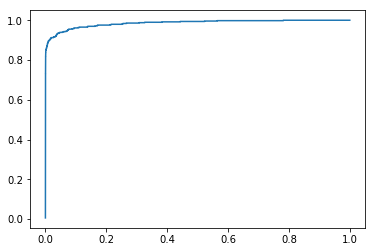

In [68]:
plt.plot(fpr_log_weight,tpr_log_weight)
plt.show()

### Oversampling and Logistic regression

In [71]:
data_0 = data[data['Class']==0]
data_1 = data[data['Class']==1]
print(data_0.shape,data_1.shape)

(284315, 31) (492, 31)


In [72]:
data_1_oversampl = resample(data_1,replace=True,n_samples=data_0.shape[0])
data_1_oversampl.shape

(284315, 31)

In [73]:
data_oversampled = pd.concat([data_0,data_1_oversampl])
data_oversampled.shape

(568630, 31)

In [74]:
data_oversampled.Class.mean()

0.5

In [75]:
X_oversampled = data_oversampled.iloc[:,:-1]
y_overampled = data_oversampled.iloc[:,-1]

In [76]:
log_pipeline = Pipeline([
    ('scaler',MinMaxScaler()),
    ('log_reg',LogisticRegression())
])
log_param = {
    'log_reg__penalty':['l2'],
    'log_reg__C':[1.0]
}

In [77]:
result_oversampled = cross_val_score(log_pipeline,X_oversampled,y_overampled,cv=KFold(5,shuffle=True),scoring='roc_auc')
print(result_oversampled.mean())

0.985870221431


In [78]:
log_pipeline.fit(X_oversampled,y_overampled)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [79]:
(fpr_oversampl,tpr_oversampl,_)=roc_curve(
    y_true=y_overampled,
    y_score=log_pipeline.predict_proba(X_oversampled)[:,1])

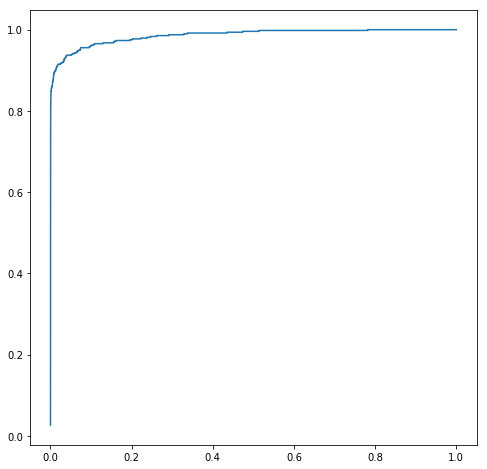

In [80]:
plt.figure(figsize=(8,8))
plt.plot(fpr_oversampl,tpr_oversampl)
plt.show()